In [107]:
# necessary imports
from joblib import Parallel, delayed

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [108]:
# choose the scaler to use
# scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = PowerTransformer()

# choose the dataset to use
# dataset_id = '1'
# dataset_id = '2'
# dataset_id = '3'
dataset_id = '4'

# tune hyerparameters
learning_rate = .5
epochs = 3000
decay_rate = 5e-3
threshold = 0.5
regularization = None
lambda_regularization = 0.0001

In [109]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.5,
                epochs=3000,
                decay_rate=5e-2,
                threshold = 0.5,
                regularization=None,
                lambda_regularization=0.0001):
        
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.decay_rate = decay_rate
        self.threshold = threshold
        self.regularization = regularization
        self.lambda_regularization = lambda_regularization
        self.weights = None                              

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    def compute_log_loss(self, y, a):
        m = y.shape[0]
        loss = -1/m * (np.sum(y * np.log(a) + (1 - y) * np.log(1 - a)))
        return loss

    def fit(self, X_train, y_train):
        # Add a column with all ones for the bias term in X_train
        X_train = np.column_stack([np.ones((X_train.shape[0], 1)), X_train])
        n_samples, n_features = X_train.shape
        self.weights = np.zeros((n_features, 1))

        for i in range(self.epochs):
            # Do matrix multiplication of X and weights
            z = np.dot(X_train, self.weights)
            # Then apply the sigmoid function
            a = self.sigmoid(z)
            diff = (a - y_train).T
            
            # Calculate the gradient ascent
            dw = (self.learning_rate * (1. / n_samples) * np.dot(diff, X_train)).T

            if self.regularization == 'l1':
                dw += (self.lambda_regularization * np.sign(self.weights))
            elif self.regularization == 'l2':
                dw += (self.lambda_regularization * self.weights)

            # Update the weights
            self.weights -= dw

            # Update the learning rate using exponential decay
            self.learning_rate = self.initial_learning_rate * np.exp(-self.decay_rate * i)
            

    def predict_probabilty(self, X_test):
        # Add a column with all ones for the bias term in X_test
        X_test = np.column_stack([np.ones((X_test.shape[0], 1)), X_test])
        linear_model = np.dot(X_test, self.weights)
        return self.sigmoid(linear_model)

    def predict(self, X_test):
        y_hat = self.predict_probabilty(X_test)
        # If the probability is greater than threshold, return 1 else 0
        return np.array([1 if i > self.threshold else 0 for i in y_hat])

In [110]:
class BaggingClassifierScratch:
    def __init__(self, base_model=LogisticRegressionScratch, n_estimators=9, sample_size=0.8):
        if not 0 < sample_size <= 1:
            raise ValueError("sample_size must be between 0 and 1")

        np.random.seed(42)
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.models = []    
        self.sample_size = sample_size

    def _fit_model(self, X_sample, y_sample):
        model = self.base_model(learning_rate=learning_rate, epochs=epochs, decay_rate=decay_rate)
        model.fit(X_sample, y_sample)
        return model

    def fit(self, X_train, y_train):
        # Create samples and fit models in parallel
        sample_count = X_train.shape[0]
        sample_indices = [
            np.random.choice(sample_count, int(sample_count * self.sample_size), replace=True)
            for _ in range(self.n_estimators)
        ]
        self.models = Parallel(n_jobs=-1)(
            delayed(self._fit_model)(                
                X_train[sample_indices[i]],
                y_train[sample_indices[i]]
            ) for i in range(self.n_estimators)
        )

    def _predict_model(self, model, X_test):
        return model.predict(X_test)

    def predict(self, X_test):
        # Get predictions from all models in parallel
        predictions = Parallel(n_jobs=-1)(
            delayed(self._predict_model)(model, X_test) for model in self.models
        )
        predictions = np.array(predictions)
        predictions = mode(predictions, axis=0).mode.T
        return predictions

    def get_estimators_predictions(self, X_test):
        # Get predictions from all models in parallel
        predictions = Parallel(n_jobs=-1)(
            delayed(self._predict_model)(model, X_test) for model in self.models
        )
        return np.array(predictions).T
    
    def _predict_probabilty(self, model, X_test):
        return model.predict_probabilty(X_test)
    
    def predict_probabilty(self, X_test):
        # Get predictions from all models in parallel
        predictions = Parallel(n_jobs=-1)(
            delayed(self._predict_model)(model, X_test) for model in self.models
        )
        predictions = np.array(predictions)
        predictions = np.mean(predictions, axis=0).T
        return predictions
    
    def get_estimators_probabilty(self, X_test):
        # Get predictions from all models in parallel
        predictions = Parallel(n_jobs=-1)(
            delayed(self._predict_probabilty)(model, X_test) for model in self.models
        )
        return np.squeeze(np.array(predictions).T)


In [111]:
class StackingClassifierScratch:
    def __init__(self, base_model=LogisticRegressionScratch, meta_model=BaggingClassifierScratch, n_estimators=9, sample_size=0.8):
        self.final_model = base_model(learning_rate=learning_rate, epochs=epochs, decay_rate=decay_rate)
        self.meta_model = meta_model(base_model, n_estimators, sample_size)
        self.n_estimators = n_estimators
        self.sample_size = sample_size        

    def fit(self, X_train, y_train, X_val, y_val):
        self.meta_model.fit(X_train, y_train)
        meta_predictions = self.meta_model.get_estimators_predictions(X_val)
        meta_features = np.column_stack([X_val, meta_predictions])
        self.final_model.fit(meta_features, y_val)

    def predict(self, X_test):
        meta_predictions = self.meta_model.get_estimators_predictions(X_test)
        meta_features = np.column_stack([X_test, meta_predictions])
        return self.final_model.predict(meta_features)
    
    def predict_probabilty(self, X_test):
        meta_predictions = self.meta_model.get_estimators_predictions(X_test)
        meta_features = np.column_stack([X_test, meta_predictions])
        return self.final_model.predict_probabilty(meta_features)    


In [112]:
# need to read and preprocess data1 so lets make a function for that
# will return a dataframe with the preprocessed data
# assuming all necessary imports are done

def read_and_preprocess_data_1():
    # read the data from appropriate location
    data_location = 'data/archive1/WA_Fn-UseC_-Telco-Customer-Churn.csv'
    df = pd.read_csv(data_location)
    
    # drop customerID column cause it is unique in all rows so it won't be useful
    df.drop('customerID', axis=1, inplace=True)

    # fix TotalCharges column by replacing empty strings with NaN and then filling them with corresponding MonthlyCharges
    # because their tenure is 0 and they haven't been charged yet, so their MonthlyCharges are their TotalCharges    
    df['TotalCharges'] = df['TotalCharges'].replace(' ', pd.NA)
    df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
    df['TotalCharges'] = df['TotalCharges'].astype('float')

    # Identify columns for different encoding and scaling
    label_encode_cols = [col for col in df.columns if df[col].nunique() <= 2]
    one_hot_encode_cols = [col for col in df.columns if 2 < df[col].nunique() < 5]
    scale_cols = [col for col in df.columns if col not in (label_encode_cols + one_hot_encode_cols)]

    # Label encode columns with 2 or fewer unique values
    for col in label_encode_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # One hot encode columns with more than 2 but fewer than 5 unique values
    df = pd.get_dummies(df, columns=one_hot_encode_cols, dtype=int, drop_first=True)

    # scale the remaining columns, choose scaler from 2nd cell of the notebook

    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    # Ensure 'Churn' is the target column [dataset specific]
    target = 'Churn'
    features = df.columns.drop(target)

    # Calculate the correlation of each feature with the target column
    correlations = df[features].corrwith(df[target])

    # Take the absolute values of the correlations
    abs_correlations = correlations.abs()

    # Sort the correlations in descending order
    sorted_correlations = abs_correlations.sort_values(ascending=False)

    # Select the top 20 features
    top_features = sorted_correlations.head(20).index

    # just keep top features and target column in df
    df = df[top_features.union([target])]

    # drop duplicate rows but keep the first one
    df.drop_duplicates(keep='first', inplace=True)

    # drop the rows where target column is NaN
    df.dropna(subset=[target], inplace=True)

    # Split the dataset into features and target
    X = df[top_features].values.astype(np.float64)
    y = df[[target]].values.astype(np.float64)

    # train test split should be 80-20, use scikit-learn's train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train validation split should be 80-20, use scikit-learn's train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [113]:
# need to read and preprocess data2 so lets make a function for that
# will return a dataframe with the preprocessed data
# assuming all necessary imports are done

def read_and_preprocess_data_2():
    # read the data from appropriate location
    # data_url = 'https://archive.ics.uci.edu/static/public/2/data.csv'
    data_location = 'data/archive2/data.csv'
    df = pd.read_csv(data_location)
    
    # replace all NaN values with '?'
    df.replace(np.nan, '?', inplace=True)

    # replace '<=50K.', '>50K.' with '<=50K', '>50K'
    df['income'] = df['income'].str.replace('.', '')

    # remove all duplicated rows but keep the first one
    df.drop_duplicates(keep='first', inplace=True)

    # Identify columns for different encoding and scaling
    # if a column has less or equal to 2 unique values, it will be label encoded
    # if a column has more than 2 but less than 50 unique values, it will be one hot encoded
    # the rest of the columns will be scaled
    label_encode_cols = [col for col in df.columns if df[col].nunique() <= 2]
    one_hot_encode_cols = [col for col in df.columns if 2 < df[col].nunique() < 50]
    scale_cols = [col for col in df.columns if col not in (label_encode_cols + one_hot_encode_cols)]

    # Label encode columns with 2 or fewer unique values
    for col in label_encode_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])    

    # One hot encode columns with fewer than 50 unique values
    df = pd.get_dummies(df, columns=one_hot_encode_cols, dtype=int, drop_first=True)

    # scale the remaining columns, choose scaler from 2nd cell of the notebook

    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    # Ensure 'income' is the target column [dataset specific]
    target = 'income'
    features = df.columns.drop(target)

    # Calculate the correlation of each feature with the target column
    correlations = df[features].corrwith(df[target])

    # Take the absolute values of the correlations
    abs_correlations = correlations.abs()

    # Sort the correlations in descending order
    sorted_correlations = abs_correlations.sort_values(ascending=False)

    # Select the top 20 features
    top_features = sorted_correlations.head(20).index

    # just keep top features and target column in df
    df = df[top_features.union([target])]

    # drop duplicate rows but keep the first one
    df.drop_duplicates(keep='first', inplace=True)

    # drop the rows where target column is NaN
    df.dropna(subset=[target], inplace=True)

    # Split the dataset into features and target
    X = df[top_features].values.astype(np.float64)
    y = df[[target]].values.astype(np.float64)

    # train test split should be 80-20, use scikit-learn's train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train validation split should be 80-20, use scikit-learn's train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [114]:
# need to read and preprocess data3 so lets make a function for that
# will return a dataframe with the preprocessed data
# assuming all necessary imports are done

def read_and_preprocess_data_3():
    # read the data from appropriate location
    data_location = 'data/archive3/creditcard.csv'
    df = pd.read_csv(data_location)
        
    # as the data is highly imbalanced, so keeping the duplicates for now
    # remove all duplicated rows but keep the first one
    # df.drop_duplicates(keep='first', inplace=True)

    # no need for any encoding

    # Ensure 'Class' is the target column [dataset specific]
    target = 'Class'
    features = df.columns.drop(target)

    # scale the remaining columns, choose scaler from 2nd cell of the notebook

    # scale the features
    df[features] = scaler.fit_transform(df[features]) 

    # Calculate the correlation of each feature with the target column
    # [no need here as the columns are already found from PCA]
    # correlations = df[features].corrwith(df[target])

    # Take the absolute values of the correlations [no need here as the columns are already found from PCA]
    # abs_correlations = correlations.abs()

    # Sort the correlations in descending order [no need here as the columns are already found from PCA]
    # sorted_correlations = abs_correlations.sort_values(ascending=False)

    # Select the top 20 features [no need here as the columns are already found from PCA]
    # top_features = sorted_correlations.head(20).index

    # as the columns are found from PCA so no need to drop any columns
    # top n features can still be selected by commenting the below line and uncommenting the above lines
    top_features = features

    # just keep top features and target column in df
    df = df[top_features.union([target])]

    # drop duplicate rows but keep the first one [not dropping duplicates for now]
    # df.drop_duplicates(keep='first', inplace=True)

    # drop the rows where target column is NaN
    df.dropna(subset=[target], inplace=True)

    # as data is highly imbalanced
    # we can keep all the rows where Class is 1
    # and keep 20000 random rows where Class is 0

    # get all the rows where Class is 1
    df_class_1 = df[df['Class'] == 1]

    # get 20000 random rows where Class is 0 
    df_class_0 = df[df['Class'] == 0].sample(n=20000, random_state=42)

    # concatenate the two dataframes
    df = pd.concat([df_class_1, df_class_0])

    # shuffle the dataframe
    df = df.sample(frac=1, random_state=42)

    # Split the dataset into features and target
    X = df[top_features].values.astype(np.float64)
    y = df[[target]].values.astype(np.float64)

    # train test split should be 80-20, use scikit-learn's train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train validation split should be 80-20, use scikit-learn's train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [115]:
def read_and_preprocess_data_4():
    # read the data from appropriate location
    data_location = 'B1.csv'
    df = pd.read_csv(data_location)

    # no need for any encoding

    # Ensure 'Class' is the target column [dataset specific]
    target = 'y'
    features = df.columns.drop(target)

    # scale the remaining columns, choose scaler from 2nd cell of the notebook

    # scale the features
    df[features] = scaler.fit_transform(df[features]) 
    
    top_features = features

    # just keep top features and target column in df
    df = df[top_features.union([target])]

    # drop duplicate rows but keep the first one [not dropping duplicates for now]
    # df.drop_duplicates(keep='first', inplace=True)

    # drop the rows where target column is NaN
    df.dropna(subset=[target], inplace=True)

    # as data is highly imbalanced
    # we can keep all the rows where Class is 1
    # and keep 20000 random rows where Class is 0

    # get all the rows where Class is 1
    df_class_1 = df[df['y'] == 1]

    # get 20000 random rows where Class is 0 
    df_class_0 = df[df['y'] == 0]

    # concatenate the two dataframes
    df = pd.concat([df_class_1, df_class_0])
    

    # Split the dataset into features and target
    X = df[top_features].values.astype(np.float64)
    y = df[[target]].values.astype(np.float64)

    # train test split should be 80-20, use scikit-learn's train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train validation split should be 80-20, use scikit-learn's train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [116]:
def read_and_preprocess_data():
    if dataset_id == '1':
        return read_and_preprocess_data_1()
    elif dataset_id == '2':
        return read_and_preprocess_data_2()
    elif dataset_id == '3':
        return read_and_preprocess_data_3()
    elif dataset_id == '4':
        return read_and_preprocess_data_4()

In [117]:
X_train, X_val, X_test, y_train, y_val, y_test = read_and_preprocess_data()

In [118]:
# Instantiate the BaggingClassifierScratch class
bagging_model = BaggingClassifierScratch(base_model=LogisticRegressionScratch,                                        
                                        n_estimators=9,
                                        sample_size=0.8)

# Fit the model
bagging_model.fit(X_train, y_train)

In [119]:
def generate_mean_stddev(model : BaggingClassifierScratch, X_test, y_test):
    y_preds = model.get_estimators_predictions(X_test)
    y_pred_probas = model.get_estimators_probabilty(X_test)

    accuracy_list = [accuracy_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    sensitivity_list = [recall_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    specificity_list = [recall_score(y_test, y_preds[:, i], pos_label=0) for i in range(model.n_estimators)]
    precision_list = [precision_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    f1_list = [f1_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    auroc_list = [roc_auc_score(y_test, y_pred_probas[:, i]) for i in range(model.n_estimators)]
    aupr_list = [average_precision_score(y_test, y_pred_probas[:, i]) for i in range(model.n_estimators)]
    
    metrics = {
        "Accuracy": accuracy_list,
        "Sensitivity": sensitivity_list,
        "Specificity": specificity_list,
        "Precision": precision_list,
        "F1-score": f1_list,
        "AUROC": auroc_list,
        "AUPR": aupr_list
    }

    df = pd.DataFrame(metrics)
    print(df)
    mean_values = df.mean()
    std_dev_values = df.std()

    print("\n\n9 Logistic Regression Learners Performance Metrics")
    print("┌─────────────┬───────────────────────────┐")
    print("│   Metric    │    Mean ± Std Dev         │")
    print("├─────────────┼───────────────────────────┤")
    for metric, mean, std_dev in zip(mean_values.index, mean_values, std_dev_values):
        print(f"│ {metric:<11} │ {mean:>10.6} ± {std_dev:<10.6f}   │")
    print("└─────────────┴───────────────────────────┘")

    return mean_values, std_dev_values


In [120]:
mean_values_lr, std_dev_values_lr = generate_mean_stddev(bagging_model, X_test, y_test)

   Accuracy  Sensitivity  Specificity  Precision  F1-score     AUROC      AUPR
0  0.358333     0.095847     0.644599   0.227273  0.134831  0.483831  0.462113
1  0.453333     0.354633     0.560976   0.468354  0.403636  0.478510  0.462001
2  0.478333     0.000000     1.000000   0.000000  0.000000  0.503234  0.470349
3  0.340000     0.009585     0.700348   0.033708  0.014925  0.508399  0.474765
4  0.510000     0.517572     0.501742   0.531148  0.524272  0.515657  0.477858
5  0.353333     0.015974     0.721254   0.058824  0.025126  0.500161  0.468308
6  0.396667     0.169329     0.644599   0.341935  0.226496  0.477396  0.460566
7  0.430000     0.000000     0.898955   0.000000  0.000000  0.504269  0.470912
8  0.340000     0.041534     0.665505   0.119266  0.061611  0.506852  0.472705


9 Logistic Regression Learners Performance Metrics
┌─────────────┬───────────────────────────┐
│   Metric    │    Mean ± Std Dev         │
├─────────────┼───────────────────────────┤
│ Accuracy    │   0.40666

/home/sabah/miniconda3/envs/472_offline_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
# print Majority Voting Ensemble Metrics
# Make predictions
y_pred = bagging_model.predict(X_test)
y_pred_proba = bagging_model.predict_probabilty(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

# Create a list of metrics and their values
metrics_voting = {
    "Accuracy": accuracy,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1-score": f1,
    "AUROC": auroc,
    "AUPR": aupr
}

# Print the table
print("Majority Voting Ensemble Performance Metrics")
print("┌─────────────┬────────────┐")
print("│   Metric    │    Value   │")
print("├─────────────┼────────────┤")
for metric, value in metrics_voting.items():
    print(f"│ {metric:<11} │ {value:>10.4f} │")
print("└─────────────┴────────────┘")

Majority Voting Ensemble Performance Metrics
┌─────────────┬────────────┐
│   Metric    │    Value   │
├─────────────┼────────────┤
│ Accuracy    │     0.3867 │
│ Sensitivity │     0.0064 │
│ Specificity │     0.8014 │
│ Precision   │     0.0339 │
│ F1-score    │     0.0108 │
│ AUROC       │     0.2340 │
│ AUPR        │     0.4214 │
└─────────────┴────────────┘


In [122]:
# Stack the models
stacked_model = StackingClassifierScratch(LogisticRegressionScratch, 
                                        BaggingClassifierScratch, 
                                        n_estimators=9,
                                        sample_size=0.8)

stacked_model.fit(X_train, y_train, X_val, y_val)

# Make predictions
y_pred = stacked_model.predict(X_test)
y_prob = stacked_model.predict_probabilty(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_prob)
aupr = average_precision_score(y_test, y_prob)

# Create a list of metrics and their values
metrics_stacking = {
    "Accuracy": accuracy,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1-score": f1,
    "AUROC": auroc,
    "AUPR": aupr
}
# Print the table about Stacking Ensemble Metrics
print("Stacking Ensemble Performance Metrics")
print("┌─────────────┬────────────┐")
print("│   Metric    │    Value   │")
print("├─────────────┼────────────┤")
for metric, value in metrics_stacking.items():
    print(f"│ {metric:<11} │ {value:>10.4f} │")
print("└─────────────┴────────────┘")

Stacking Ensemble Performance Metrics
┌─────────────┬────────────┐
│   Metric    │    Value   │
├─────────────┼────────────┤
│ Accuracy    │     0.8667 │
│ Sensitivity │     0.9010 │
│ Specificity │     0.8293 │
│ Precision   │     0.8520 │
│ F1-score    │     0.8758 │
│ AUROC       │     0.9186 │
│ AUPR        │     0.8952 │
└─────────────┴────────────┘


In [123]:
# Print the LaTeX table
print(r"\begin{table}[h!]")
print(r"\centering")
print(r"\caption{Performance on Test set}")
print(r"\begin{adjustbox}{width=\textwidth}")
print(r"\begin{tabular}{|c|c|c|c|c|c|c|c|}")
print(r"\hline")
print(r"  & Accuracy & Sensitivity & Specificity & Precision & F1-score & AUROC & AUPR \\")
print(r"\hline")
print(f"LR* & {mean_values_lr['Accuracy']:.4f} ± {std_dev_values_lr['Accuracy']:.4f} & {mean_values_lr['Sensitivity']:.4f} ± {std_dev_values_lr['Sensitivity']:.4f} & {mean_values_lr['Specificity']:.4f} ± {std_dev_values_lr['Specificity']:.4f} & {mean_values_lr['Precision']:.4f} ± {std_dev_values_lr['Precision']:.4f} & {mean_values_lr['F1-score']:.4f} ± {std_dev_values_lr['F1-score']:.4f} & {mean_values_lr['AUROC']:.4f} ± {std_dev_values_lr['AUROC']:.4f} & {mean_values_lr['AUPR']:.4f} ± {std_dev_values_lr['AUPR']:.4f} \\\\")
print(r"\hline")
print(f"Voting Ensemble & {metrics_voting['Accuracy']:.4f} & {metrics_voting['Sensitivity']:.4f} & {metrics_voting['Specificity']:.4f} & {metrics_voting['Precision']:.4f} & {metrics_voting['F1-score']:.4f} & {metrics_voting['AUROC']:.4f} & {metrics_voting['AUPR']:.4f} \\\\")
print(r"\hline")
print(f"Stacking Ensemble & {metrics_stacking['Accuracy']:.4f} & {metrics_stacking['Sensitivity']:.4f} & {metrics_stacking['Specificity']:.4f} & {metrics_stacking['Precision']:.4f} & {metrics_stacking['F1-score']:.4f} & {metrics_stacking['AUROC']:.4f} & {metrics_stacking['AUPR']:.4f} \\\\")
print(r"\hline")
print(r"\end{tabular}")
print(r"\end{adjustbox}")
print(r"\end{table}")

\begin{table}[h!]
\centering
\caption{Performance on Test set}
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
  & Accuracy & Sensitivity & Specificity & Precision & F1-score & AUROC & AUPR \\
\hline
LR* & 0.4067 ± 0.0639 & 0.1338 ± 0.1845 & 0.7042 ± 0.1565 & 0.1978 ± 0.2051 & 0.1545 ± 0.1927 & 0.4976 ± 0.0140 & 0.4688 ± 0.0061 \\
\hline
Voting Ensemble & 0.3867 & 0.0064 & 0.8014 & 0.0339 & 0.0108 & 0.2340 & 0.4214 \\
\hline
Stacking Ensemble & 0.8667 & 0.9010 & 0.8293 & 0.8520 & 0.8758 & 0.9186 & 0.8952 \\
\hline
\end{tabular}
\end{adjustbox}
\end{table}


In [124]:
def generate_violon_plot(model : BaggingClassifierScratch, X_test, y_test):
    y_preds = model.get_estimators_predictions(X_test)
    y_pred_probas = model.get_estimators_probabilty(X_test)

    accuracy_list = [accuracy_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    sensitivity_list = [recall_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    specificity_list = [recall_score(y_test, y_preds[:, i], pos_label=0) for i in range(model.n_estimators)]
    precision_list = [precision_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    f1_list = [f1_score(y_test, y_preds[:, i]) for i in range(model.n_estimators)]
    auroc_list = [roc_auc_score(y_test, y_pred_probas[:, i]) for i in range(model.n_estimators)]
    aupr_list = [average_precision_score(y_test, y_pred_probas[:, i]) for i in range(model.n_estimators)]
    
    metrics = {
        "Accuracy": accuracy_list,
        "Sensitivity": sensitivity_list,
        "Specificity": specificity_list,
        "Precision": precision_list,
        "F1-score": f1_list,
        "AUROC": auroc_list,
        "AUPR": aupr_list
    }

    df = pd.DataFrame(metrics)
    df = df.melt(var_name='Metrics', value_name='Values')

    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Metrics', y='Values', data=df, palette="Set3", hue='Metrics', legend=False)
    plt.title('Violin Plot of Metrics for 9 Bagging Learners')
    # plt.savefig(f"data/violin_plots/{scaler.__class__.__name__}_dataset_{dataset_id}_violin_plot.png")
    plt.show()
    plt.close()


/home/sabah/miniconda3/envs/472_offline_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


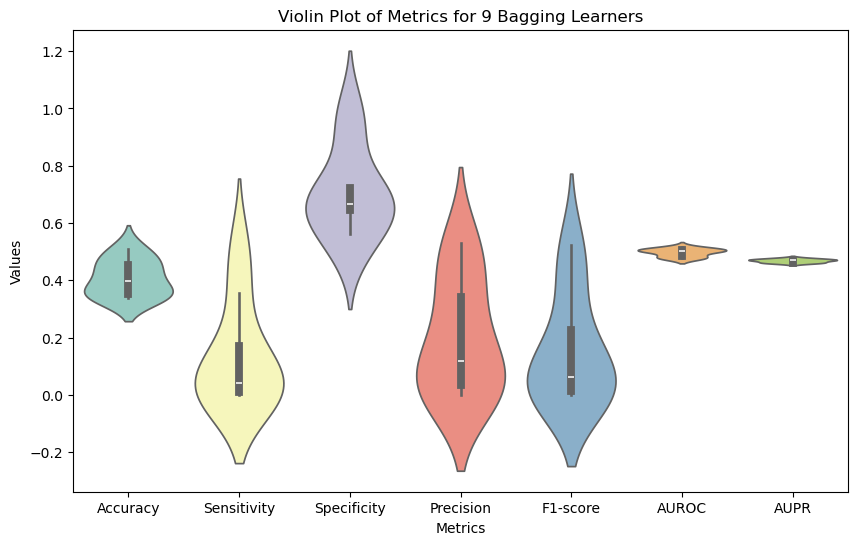

In [125]:
generate_violon_plot(bagging_model, X_test, y_test)

In [126]:
# from joblib import Parallel, delayed
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score

# # Assuming LogisticRegressionScratch, X_train, y_train, X_val, y_val are defined

# epochs = range(100, 6000, 200)

# def train_and_evaluate(epoch, learning_rate, decay_rate, X_train, y_train, X_val, y_val):
#     model = LogisticRegressionScratch(learning_rate=learning_rate, epochs=epoch, decay_rate=decay_rate)
#     model.fit(X_train, y_train)
#     y_val_pred_prob = model.predict_probabilty(X_val)
#     loss = model.compute_log_loss(y_val, y_val_pred_prob)
#     y_val_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_val_pred)
#     return loss, accuracy, model

# np.random.seed(42)
# sample_indices = [
#     np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.8), replace=True)
#     for _ in range(len(epochs))
# ]

# # Parallelize the training and evaluation
# results = Parallel(n_jobs=-1)(
#     delayed(train_and_evaluate)(
#         epoch, learning_rate, decay_rate,
#         X_train[sample_indices[i]], y_train[sample_indices[i]],
#         X_val, y_val
#     ) for i, epoch in enumerate(epochs)
# )

# # Separate the results into losses and accuracies
# losses = [result[0] for result in results]
# accuracies = [result[1] for result in results]
# models = [result[2] for result in results]

# # Plot Log Loss vs Epochs
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o')
# plt.title('Log Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Log Loss')
# plt.show()

# # Plot Accuracy vs Epochs
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, accuracies, marker='o')
# plt.title('Accuracy vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

In [127]:
# # do inidvidual predictions on X_test by each model parallelly and plot the loss and accuracy
# def evaluate_model(model, X_test, y_test):
#     y_test_pred_prob = model.predict_probabilty(X_test)
#     loss = model.compute_log_loss(y_test, y_test_pred_prob)
#     y_test_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_test_pred)
#     return loss, accuracy

# results = Parallel(n_jobs=-1)(
#     delayed(evaluate_model)(model, X_test, y_test) for model in models
# )

# # Separate the results into losses and accuracies
# losses, accuracies = zip(*results)

# # Plot Log Loss vs Epochs
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o')
# plt.title('Log Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Log Loss')
# plt.show()

# # Plot Accuracy vs Epochs
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, accuracies, marker='o')
# plt.title('Accuracy vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()